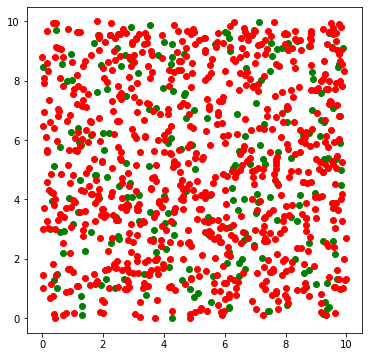

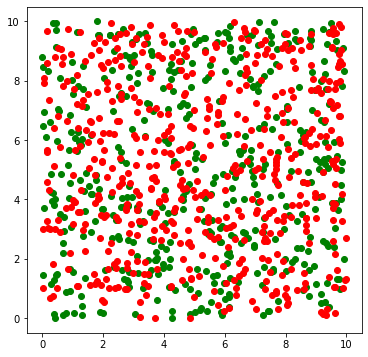

In [215]:
"""Test of the probability mass function for solar model distribution.

Locations are saved as 3-tuple (x, y, b, Y), where b = solar panel installed?


@author: Damian Hoedtke
@date: Jun, 2021

"""

import numpy as np
from numpy import array
import matplotlib.pyplot as plt


# constants
N = 1000
L = 10

def create_initial_distribution():
    np.random.seed(0)
    state = np.random.rand(N, 4) # x, y, b, Y (socioeconomic factors)
    state[:, :2] *= L
    
    state[:, 3] *= 1.0
    
    # probability of solar cell
    p_cell = 0.2
    state[:, 2] = state[:, 2] < p_cell 
    
    return state

def plot_distribution(state):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    cells = state[state[:, 2] == True]
    empty = state[state[:, 2] == False]
    
    ax.scatter(cells[:,0], cells[:,1], color='green')
    ax.scatter(empty[:,0], empty[:,1], color='red')
    
    
def dist2(r1, r2):
    """Caculate shortest distance between r1 and r2 with periodic boundary conditions."""
    # longest possible distance in x / y direction given by L / 2
    dr = abs(r1 - r2)
    
    if dr[0] > L/2:
        dr[0] = L - dr[0]
        
    
    if dr[1] > L/2:
        dr[1] = L - dr[1]
    
    return dr[0] * dr[0] + dr[1] * dr[1]
    
    
def mc_step(state, all_dists):
    
    n_flips = 0
    
    for i, (x, y, b, Y) in enumerate(state):
        
        # calculate probability
        # p_i = nr^-1 sum( beta (rho - 0.5) + 0.5)
        
        rhos = []
        rs = np.arange(0.5, 3.0, 0.5)
        nr = rs.size
        
        p_i = 0.0
    
        for r in rs:
            # calculate density
            
            cells = state[all_dists[i, :] <= r * r][:, 2]
            
            rho = (np.count_nonzero(cells) - int(b)) / cells.size
            rhos.append(rho)
            
            p_i += (2.5 * np.exp(-r) * (rho - Y)) + Y
        
        p_i /= nr
        
        p_i *= 0.8
        p_i += 0.2 * 0.5 # random modification
        
        #print(x, y, b, rhos)
        
        # update solar module
        rand = np.random.rand(1)
        state[i, 2] = p_i > rand
        
        if state[i, 2] != b:
            n_flips += 1
        
    return state, n_flips
    
    

# create initial distribution
state = create_initial_distribution()

# plot initial distribution
plot_distribution(state)


# calculate distances
all_dists = np.zeros((N, N))
for i in range(N-1):
    for j in range(i + 1, N, 1):
        d2 = dist2(state[i, :2], state[j, :2])
        all_dists[i, j] = d2
        all_dists[j, i] = d2
    
n_steps = 700
n_cells, n_flips = [], []
for i in range(n_steps):
    state, flips = mc_step(state, all_dists)
    n_cells.append(np.count_nonzero(state[:, 2]))
    n_flips.append(flips)

plot_distribution(state)

plt.show()

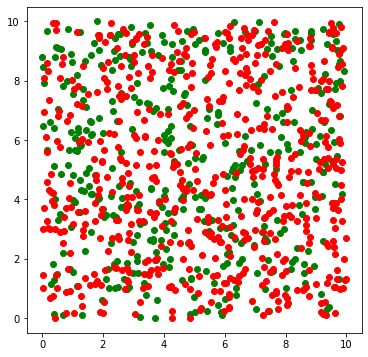

In [216]:
nstate, flips = mc_step(state, all_dists)
plot_distribution(nstate)

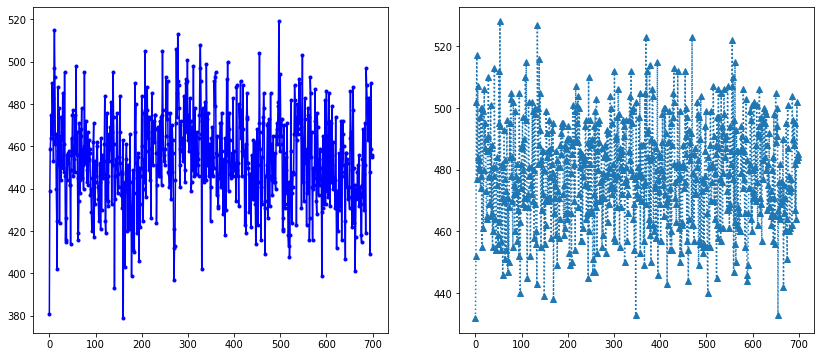

In [217]:
# plot number of cells
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(n_cells, 'b.-')
ax2.plot(n_flips, '^:')

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier as RF

rs = [0.5, 1, 1.5, 2, 2.5, 3]

# for each value of r / r0 calculate feature importances
importances, errors = [], []
previous_rhos = np.zeros(N)
for r in rs:
    
    # calculate density for each location
    rhos = []
    loc_in_range = all_dists <= r * r
    
    for k in range(N):
        cells = state[loc_in_range[k]][:, 2]
        rhos.append(np.count_nonzero(cells) / cells.size)
    
    rhos = array(rhos)
    subtracted_rhos = rhos - previous_rhos
    
    data = np.zeros((N, 2))

    data[:, 0] = state[:, 3] # Y data
    data[:, 1] = subtracted_rhos
                    
    targets = state[:, 2]
    
    X_train, X_test, y_train, y_test = train_test_split(
        data, targets, random_state=0)
    
    model = RF(n_estimators=20).fit(X_train, y_train)
    
    print(model.score(X_test, y_test))
    
    # calculate importances
    imp = permutation_importance(model, X_test, y_test, 
                               n_repeats=30, random_state=0)
    
    importances.append(imp.importances_mean)
    errors.append(imp.importances_std)
    print(imp.importances_mean, imp.importances_std)
    
    previous_rhos = rhos

importances = array(importances)
errors = array(errors)

0.648
[-0.01213333  0.12826667] [0.02184755 0.02876912]
0.612
[-0.02466667  0.07466667] [0.0226058  0.02645919]
0.544
[-0.00653333  0.0076    ] [0.0261989  0.03315177]
0.604
[0.06213333 0.06026667] [0.02969594 0.02523349]
0.56
[0.0368     0.02213333] [0.02524335 0.0249743 ]
0.56
[0.02973333 0.02106667] [0.02969504 0.0243515 ]


<function matplotlib.pyplot.show(close=None, block=None)>

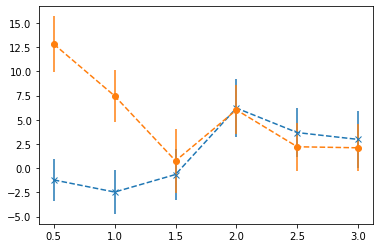

In [219]:
plt.figure()
plt.errorbar(rs, importances[:, 0] * 100, yerr=errors[:, 0] * 100, fmt='x--')
plt.errorbar(rs, importances[:, 1] * 100, yerr=errors[:, 1] * 100, fmt='o--')
plt.show

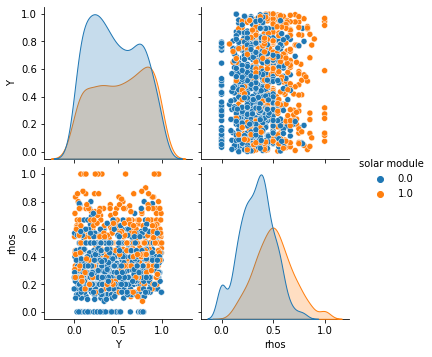

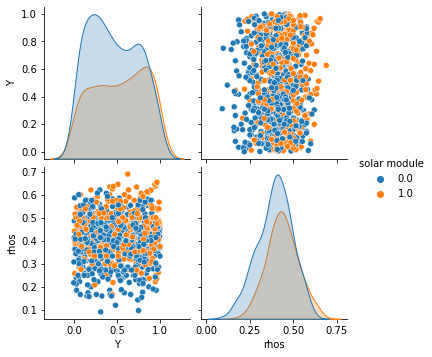

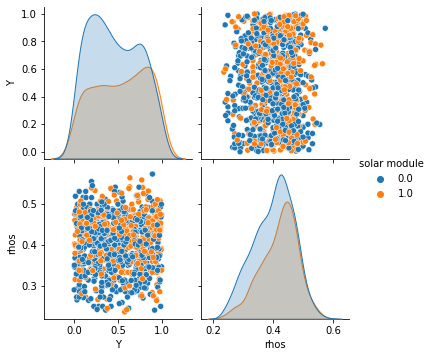

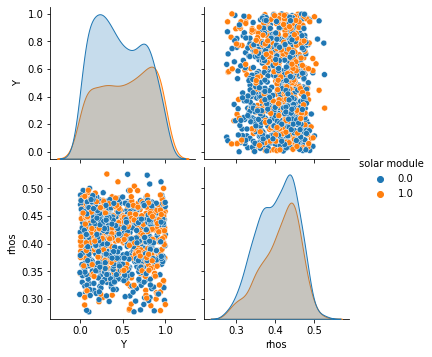

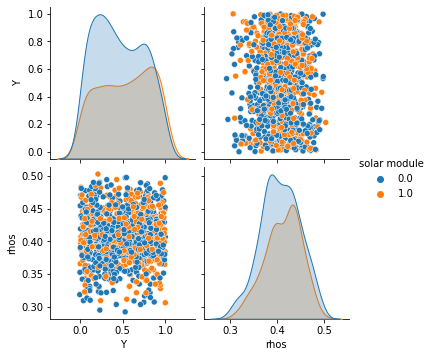

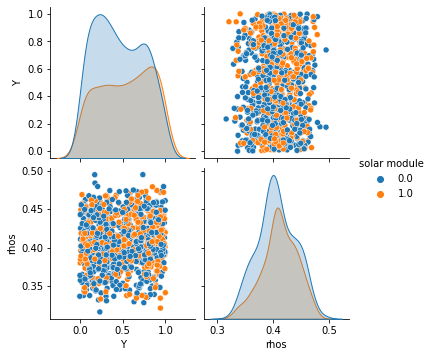

In [225]:
from pandas import DataFrame
from seaborn import pairplot

rs = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# for each value of r / r0 calculate feature importances
importances, errors = [], []
previous_rhos = np.zeros(N)
for r in rs:
    
    # calculate density for each location
    rhos = []
    loc_in_range = all_dists <= r * r
    
    for k in range(N):
        cells = state[loc_in_range[k]][:, 2]
        rhos.append(np.count_nonzero(cells) / cells.size)
    
    rhos = array(rhos)
    subtracted_rhos = rhos - previous_rhos
    
    data = np.zeros((N, 3))

    data[:, 0] = state[:, 3] # Y data
    data[:, 1] = subtracted_rhos
                    
    data[:, 2] = state[:, 2]
    
    columns = ["Y", "rhos", "solar module"]
    df = DataFrame(data=data, columns=columns)
    
    pairplot(df, hue='solar module')
    

In [126]:
from numpy import loadtxt

# load data
state = loadtxt("distribution.txt", dtype="float64", delimiter=",")
N = state.shape[0]
L = 20

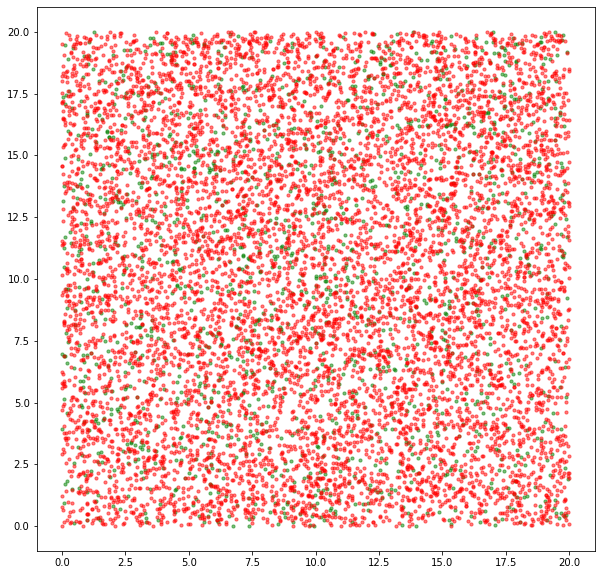

In [127]:
import matplotlib.pyplot as plt

def plot_distribution(state):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    cells = state[state[:, 2] == True]
    empty = state[state[:, 2] == False]
    
    ax.scatter(cells[:,0], cells[:,1], color='green', s= 10, alpha=0.5)
    ax.scatter(empty[:,0], empty[:,1], color='red', s=10, alpha=0.5)

plot_distribution(state)

In [128]:
from scipy.spatial.distance import pdist, squareform

X = state[:, :2]
all_dists = squareform(pdist(X))

0.8564
[-0.0024  0.1016] [0.00395171 0.00877086]
0.8628
[0.00072 0.09904] [0.00443549 0.00411125]
0.8088
[-0.00156  0.00732] [0.00462151 0.00442556]
0.8076
[0.00312 0.00556] [0.00312819 0.00434309]
0.8068
[0.00444 0.00088] [0.00420837 0.00565063]
0.7972
[-0.00252 -0.00244] [0.00383687 0.0057116 ]
0.8028
[ 0.00068 -0.00068] [0.00501215 0.00433424]
0.802
[-0.00716 -0.00644] [0.00534401 0.00297429]
0.8016
[ 0.00032 -0.00024] [0.00587006 0.00508236]
0.804
[-0.00472 -0.00156] [0.00418301 0.00498141]


<function matplotlib.pyplot.show(close=None, block=None)>

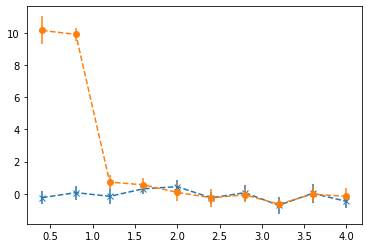

In [129]:
from numpy import array
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier as RF

rs = [i * 0.4 for i in range(1, 11)]

# for each value of r / r0 calculate feature importances
importances, errors = [], []
previous_rhos = np.zeros(N)
for r in rs:
    
    # calculate density for each location
    rhos = []
    loc_in_range = all_dists <= r * r
    
    for k in range(N):
        cells = state[loc_in_range[k]][:, 2]
        rhos.append(np.count_nonzero(cells) / cells.size)
    
    rhos = array(rhos)
    subtracted_rhos = rhos - previous_rhos
    
    data = np.zeros((N, 2))

    data[:, 0] = state[:, 3] # Y data
    data[:, 1] = subtracted_rhos
                    
    targets = state[:, 2]
    
    X_train, X_test, y_train, y_test = train_test_split(
        data, targets, random_state=0)
    
    model = RF(n_estimators=200).fit(X_train, y_train)
    
    print(model.score(X_test, y_test))
    
    # calculate importances
    imp = permutation_importance(model, X_test, y_test, 
                               n_repeats=10, random_state=0)
    
    importances.append(imp.importances_mean)
    errors.append(imp.importances_std)
    print(imp.importances_mean, imp.importances_std)
    
    previous_rhos = rhos

importances = array(importances)
errors = array(errors)

plt.figure()
plt.errorbar(rs, importances[:, 0] * 100, yerr=errors[:, 0] * 100, fmt='x--')
plt.errorbar(rs, importances[:, 1] * 100, yerr=errors[:, 1] * 100, fmt='o--')
plt.show

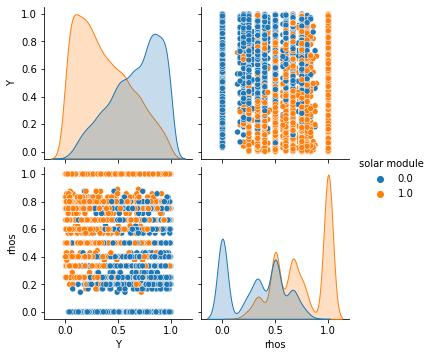

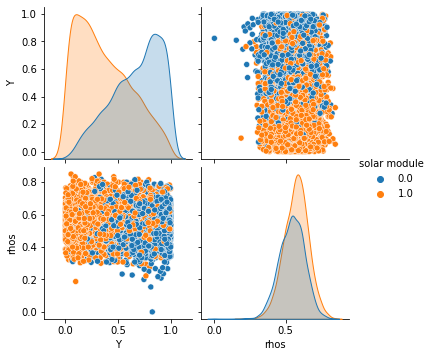

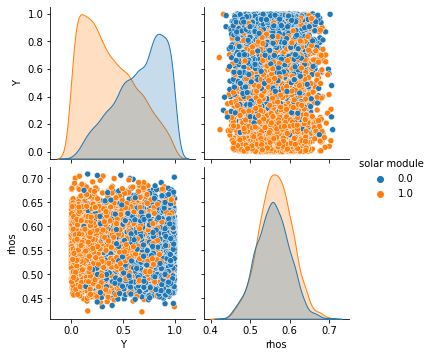

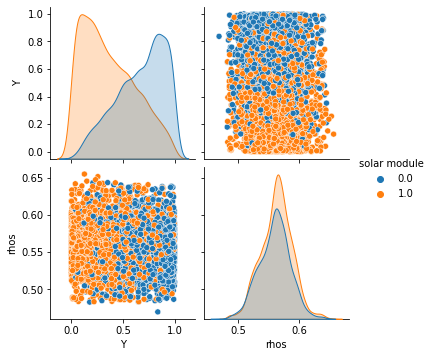

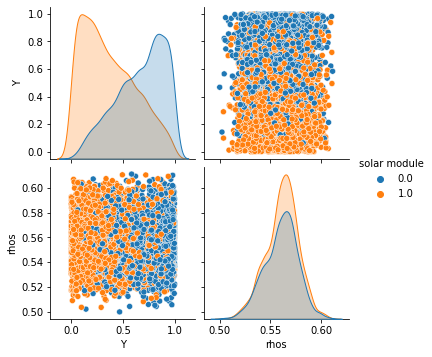

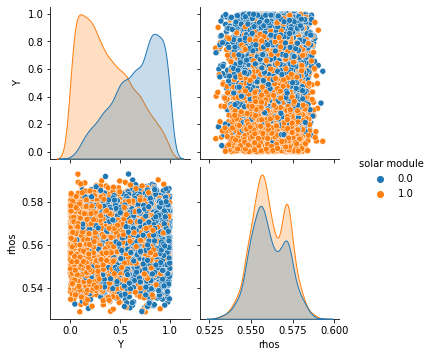

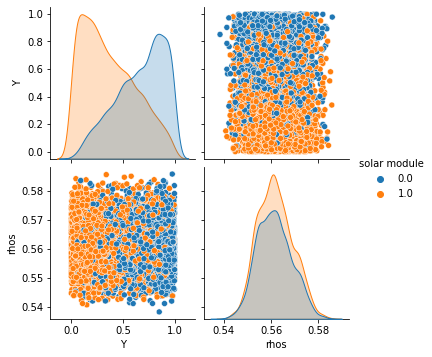

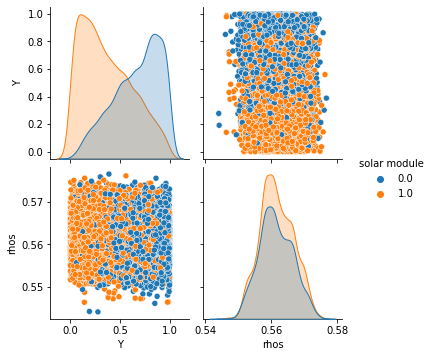

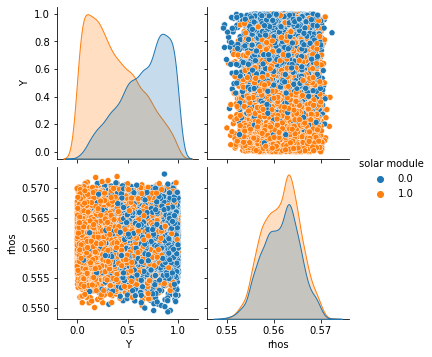

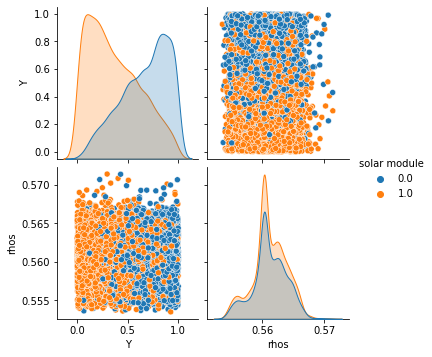

In [108]:
from pandas import DataFrame
from seaborn import pairplot

rs = [i * 0.4 for i in range(1, 11)]

# for each value of r / r0 calculate feature importances
importances, errors = [], []
previous_rhos = np.zeros(N)
for r in rs:
    
    # calculate density for each location
    rhos = []
    loc_in_range = all_dists <= r * r
    
    for k in range(N):
        cells = state[loc_in_range[k]][:, 2]
        rhos.append(np.count_nonzero(cells) / cells.size)
    
    rhos = array(rhos)
    subtracted_rhos = rhos - previous_rhos
    
    data = np.zeros((N, 3))

    data[:, 0] = state[:, 3] # Y data
    data[:, 1] = subtracted_rhos
                    
    data[:, 2] = state[:, 2]
    
    columns = ["Y", "rhos", "solar module"]
    df = DataFrame(data=data, columns=columns)
    
    pairplot(df, hue='solar module')
    

Real inital desity n_i = 0.0217

Elapsed time 55.393829


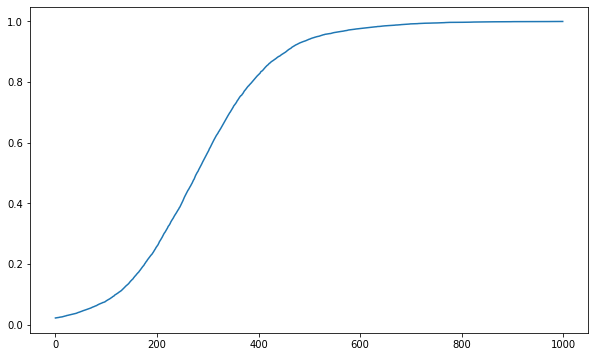

In [210]:
"""Simple Proximity Dynamics Model.

Model the network dynamics of solar panel installation
by assuming panel proximity as the main determining variable.

"""
from time import time

from numpy import array, dot, exp
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

# model parameters
#
# all distances are normalized by r0 = 210 m
# i.e. r = 20 corresponds to r_real = 210 * 20 = 4.2 km

# area under test L^2
L = 20

# number of addresses
N = 10000

# initial panel density
n0 = 0.02

seed(0)

# create pseudo-random locations
locs = rand(N, 2) * L
all_dist = squareform(pdist(locs))

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]

n_steps = 1000
densities = []

tStart = time()

for _ in range(n_steps):
    mc_step(locs, state)
    densities.append(density(state))

elapsed = time() - tStart
print("Elapsed time %f" % elapsed)
    
fig = plt.figure(figsize=(10, 6))
plt.plot(densities)


162.41700305834152